In [1]:
from superminddpm import DDPM, DummyEpsModel
import torch
import matplotlib.pyplot as plt

c:\Users\willd\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = DDPM(eps_model=DummyEpsModel(1), betas=(1e-4, 0.02), n_T=1000)
model.load_state_dict(torch.load("./contents/ddpm_mnist.pth", map_location="cpu"))
model.to("cpu")
model.eval();

Model created


In [14]:
dataset = torch.load("./datasets/1000_samples.pth")

n = dataset.shape[0]
samples = dataset[:, 0][:, None, ...]
original_noise = dataset[:, 1][:, None, ...]
samples = samples + 0.5
labels = torch.load(f"./datasets/{n}_labels.pth")

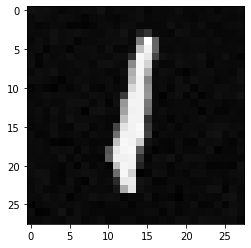

In [15]:
index = torch.randint(0, n, (1,))[0]
sample = samples[index]
starting_noise = original_noise[index]
plt.imshow(sample[0], cmap="gray")
plt.show()

In [21]:
with torch.no_grad():
    result = model.sample(1, (1, 28, 28), starting_noise=starting_noise[None, ...], device="cpu", return_at_step=900)

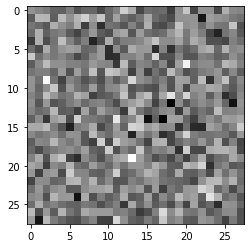

In [20]:
plt.imshow(result[0][0], cmap="gray")
plt.show()